In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def detect_lines(img, threshold1 = 10, threshold2 = 20, apertureSize = 3, minLineLength = 800, maxLineGap = 100):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1 = threshold1, threshold2 = threshold2, apertureSize = apertureSize) # detect edges
    lines = cv2.HoughLinesP(
                    edges,
                    1,
                    np.pi/180,
                    100,
                    minLineLength = minLineLength,
                    maxLineGap = maxLineGap,
            ) # detect lines
    return lines

In [122]:
def draw_lines(img,lines, color = (0,255,0)):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), color, 2)
    plt.imshow(img)

In [4]:
def get_slopes_intercepts(lines):
    slopes = []
    intercepts = []
    for line in lines:
        x1,y1,x2,y2 = line[0]
        slope = (y2-y1)/(x2-x1)
        inverse_slope = (x2-x1)/(y2-y1)
        intercept = x1 - y1*inverse_slope
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts

In [191]:
def detect_lanes(lines):
    # group lines based on slope
    slopes,intercepts = get_slopes_intercepts(lines)
    linesGroup = []
    for i in range(len(lines)):
        if (i == 0):
            linesGroup.append([lines[i]])
        else:
            slope = slopes[i]
            added = False 
            for group in linesGroup:
                x1,y1,x2,y2 = group[0][0]
                slope2 = (y2-y1)/(x2-x1)
                
                if (np.abs(1.0-slope/slope2) < 0.05): # error within 5%
                    group.append(lines[i])
                    added = True
            if (not added):
                linesGroup.append([lines[i]])
    
    # create singular line from a group of lines
    lessLines = []
    for group in linesGroup:
        x1,y1,x2,y2 = float('inf'),float('inf'),float('-inf'),float('-inf')
        for line in group:
            l = line[0]
            if (l[0] < x1 and l[1] < y1):
                x1,y1 = l[0],l[1]
            if (l[2] > x2 and l[3] > y2):
                x2,y2 = l[2],l[3]
        lessLines.append(np.array([[x1,y1,x2,y2]]))
    
    # sort based on slope
    lanes = []
    slopes, intercepts = get_slopes_intercepts(lessLines)
    slopesArgs = np.argsort(slopes)

    # need to change so sorted range goes from barely neg to max neg to max pos to barely pos
    i = 0
    while (i < len(slopesArgs)):
        if (slopes[slopesArgs[i]] > 0):
            slice = slopesArgs[0:i]
            slice = slice[::-1]
            slopesArgs[0:i] = slice
            break
        i += 1
    
    i = len(slopesArgs)-1
    while (i >= 0):
        if (slopes[slopesArgs[i]] < 0):
            slice = slopesArgs[i+1:len(slopesArgs)-1]
            slice = slice[::-1]
            slopesArgs[i+1:len(slopesArgs)-1] = slice
            break
        i -= 1
        
    sortedSlopes = []
    sortedLines = []
    for i in range(len(lessLines)):
        sortedLines.append(lessLines[slopesArgs[i]])
        sortedSlopes.append(slopes[slopesArgs[i]])

    # finding lanes
    slopes = sortedSlopes
    i = 1
    while i < len(sortedLines)-1:
        line = sortedLines[i]
        slope = slopes[i]
        x1,y1,x2,y2 = line[0]
        intercept = (2000-y1)/slope + x1

        x1,y1,x2,y2 = sortedLines[i-1][0]
        prevIntercept = (2000-y1)/slope + x1

        x1,y1,x2,y2 = sortedLines[i+1][0]
        nextIntercept = (2000-y1)/slope + x1
        if (np.abs(1.0-slope/slopes[i-1]) < np.abs(1.0-slope/slopes[i+1]) and np.abs(intercept-prevIntercept)<np.abs(intercept-nextIntercept) and np.abs(intercept-prevIntercept) < 2000):
            lanes.append([sortedLines[i-1],sortedLines[i]])
        elif (np.abs(1.0-slope/slopes[i-1]) >= np.abs(1.0-slope/slopes[i+1]) and np.abs(intercept-prevIntercept)>=np.abs(intercept-nextIntercept) and np.abs(intercept-nextIntercept) < 2000):
            lanes.append([sortedLines[i],sortedLines[i+1]])
        i+=1

    return lanes


In [110]:
def draw_lanes(img, lanes):
    for lane in lanes:
        line1,line2 = lane[0], lane[1]
        x1, y1, x2, y2 = line1[0]
        line1x1,line1y1,line1x2,line1y2 = line1[0]
        line2x1,line2y1,line2x2,line2y2 = line2[0]
        # average points
        x1 = (line1x1 + line2x1)/2
        y1 = (line1y1 + line2y1)/2
        x2 = (line1x2 + line2x2)/2
        y2 = (line1y2 + line2y2)/2
        # print (x1,y1,x2,y2)
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

    plt.imshow(img)

[4 3 2 5 1 0]
[5 2 3 4 1 0]


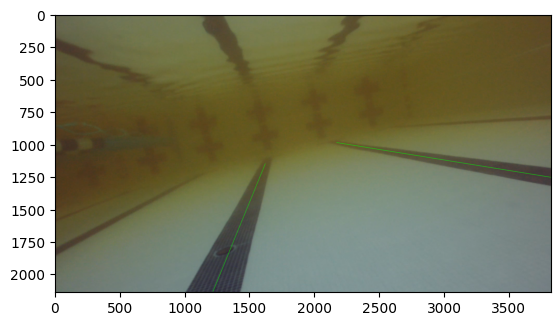

In [192]:
img = cv2.imread("Image.png")
lines = detect_lines(img,minLineLength = 900)
# draw_lines(img,lines)
slopes, intercepts = get_slopes_intercepts(lines)
lanes = detect_lanes(lines)
draw_lanes(img,lanes)